<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Resumen" data-toc-modified-id="Resumen-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Resumen</a></span></li><li><span><a href="#Por-año,-desde-dónde-llegan-más-vuelos?" data-toc-modified-id="Por-año,-desde-dónde-llegan-más-vuelos?-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Por año, desde dónde llegan más vuelos?</a></span></li><li><span><a href="#Por-año,-hacia-dónde-salen-más-vuelos?" data-toc-modified-id="Por-año,-hacia-dónde-salen-más-vuelos?-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Por año, hacia dónde salen más vuelos?</a></span></li><li><span><a href="#Aeropuertos-nacionales-más-activos" data-toc-modified-id="Aeropuertos-nacionales-más-activos-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Aeropuertos nacionales más activos</a></span><ul class="toc-item"><li><span><a href="#Mapa" data-toc-modified-id="Mapa-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Mapa</a></span></li></ul></li><li><span><a href="#Actividad-por-mes" data-toc-modified-id="Actividad-por-mes-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Actividad por mes</a></span></li><li><span><a href="#Vuelos-Cabotaje/Internacional" data-toc-modified-id="Vuelos-Cabotaje/Internacional-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Vuelos Cabotaje/Internacional</a></span></li></ul></div>

# Resumen

En este reporte se analizan los datos que registra EANA sobre los despegues y aterrizajes en aeorpuertos nacionales.
Los datos los publica el ministerio de transporte.

Se incluyen datos de la OACI, para recuperar latitud y longitud de los aeropuertos.

In [4]:
#Imports iniciales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import os
import seaborn as sns
from unidecode import unidecode 
import geopandas as gpd
from shapely.geometry import Point
import locale
#defino lenguaje
locale.setlocale(locale.LC_ALL, 'es_AR.utf8');
import calendar

%matplotlib inline

In [5]:
#Carga de datos
eana = pd.read_csv('./input/eana.csv',sep=';',encoding='latin1')
airports = pd.read_csv('./input/airports.csv', encoding='utf8')

#parseo la fecha
eana['fecha_parseada'] = pd.to_datetime(eana['Fecha']+eana['Hora Movimiento HHMM'],format='%d/%m/%Y%H:%M')

#normalizo nombres de columnas de eana.
eana.columns = eana.columns.map(unidecode).str.lower().str.replace(' ','_')

In [6]:
eana = eana.dropna(subset=['fecha_parseada'])
#agrego columna anio y mes
eana['anio'] = eana.fecha_parseada.dt.year
# eana['mes'] = eana.fecha_parseada.dt.month.astype(int).apply(lambda x: calendar.month_abbr[x]) #eana.Fecha_parseada.dt.month
eana['mes'] = eana.fecha_parseada.dt.month.astype(int)

# Por año, desde dónde llegan más vuelos?

In [7]:
movimiento = eana.tipo_de_movimiento.str.contains('Aterrizaje') & eana.clasificacion_vuelo.str.contains('Internacional')
ranking_head = pd.DataFrame()

anios_rango_raw = eana.anio.unique()
anios_rango = anios_rango_raw[~np.isnan(anios_rango_raw)]

for anio in anios_rango:
    ranking = (eana[movimiento & (eana.fecha_parseada.dt.year == anio)].groupby(['origen_oaci']).size().sort_values(ascending=False))
    ranking_head = ranking_head.append(ranking.head(6),ignore_index=True)

base = np.int(eana.anio.min())
ranking_head.index = range(base ,len(ranking_head)+ base )


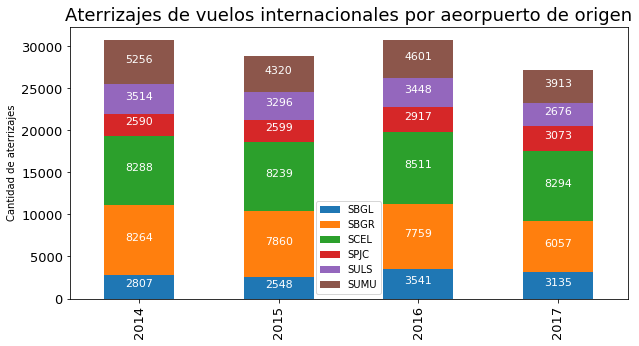

In [8]:
#plot
ax = ranking_head.plot(kind='bar', figsize=(10,5), fontsize=13, stacked=True);
ax.set_alpha(0.8)
ax.set_title("Aterrizajes de vuelos internacionales por aeorpuerto de origen", fontsize=18)
ax.set_ylabel("Cantidad de aterrizajes")

# create a list to collect the plt.patches data
totals = pd.DataFrame()

# find the values and append to list
for i in ax.patches:
    totals = totals.append(pd.DataFrame([[i.get_x(), i.get_height()]]),ignore_index=True)
totals.columns = ['x','y']

count = 0
for i in ax.patches:

    # get_x pulls left or right; get_height pushes up or down
    x_es_igual = totals.x == i.get_x()
    y_es_igual = totals.y == i.get_height()

    totals_x = totals[x_es_igual].reset_index(drop=True)
    index_es_menor_igual = totals_x.index.values <= count/totals.x.nunique()
            
    total = totals_x.y.sum()
    
    ax.text(i.get_x()+.15, totals_x[index_es_menor_igual].y.sum()-i.get_height()/2-5, \
#             str(round((totals[x_es_igual & y_es_igual].y.sum()/total)*100, 2))+'%', fontsize=11,
            str(np.int(totals[x_es_igual & y_es_igual].y.sum())), fontsize=11,
            color='white')    
    count+=1

# Por año, hacia dónde salen más vuelos?

In [9]:
movimiento = eana.tipo_de_movimiento.str.contains('Despegue') & eana.clasificacion_vuelo.str.contains('Internacional')
ranking_head = pd.DataFrame()

anios_rango_raw = eana.anio.unique()
anios_rango = anios_rango_raw[~np.isnan(anios_rango_raw)]

for anio in anios_rango:
    ranking = (eana[movimiento & (eana.fecha_parseada.dt.year == anio)].groupby(['destino_oaci']).size().sort_values(ascending=False))
    ranking_head = ranking_head.append(ranking.head(6),ignore_index=True)

base = np.int(eana.anio.min())
ranking_head.index = range(base ,len(ranking_head)+ base )


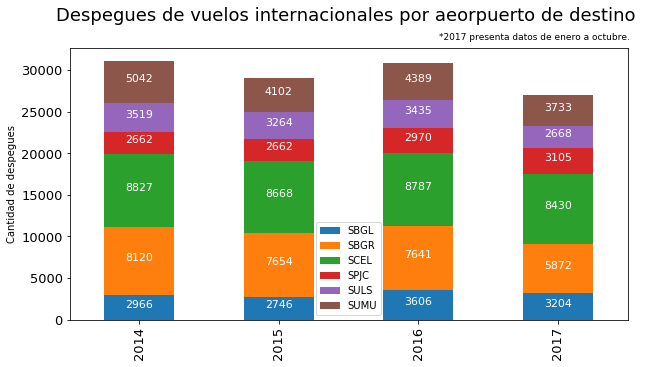

In [10]:
#plot
ax = ranking_head.plot(kind='bar', figsize=(10,5), fontsize=13, stacked=True);
ax.set_alpha(0.8)
ax.set_title("Despegues de vuelos internacionales por aeorpuerto de destino \n", fontsize=18)
ax.set_ylabel("Cantidad de despegues")

# create a list to collect the plt.patches data
totals = pd.DataFrame()

# find the values and append to list
for i in ax.patches:
    totals = totals.append(pd.DataFrame([[i.get_x(), i.get_height()]]),ignore_index=True)
totals.columns = ['x','y']

ax.text(2.15, 33700, '*2017 presenta datos de enero a octubre.',fontsize=9) 


count = 0
for i in ax.patches:

    # get_x pulls left or right; get_height pushes up or down
    x_es_igual = totals.x == i.get_x()
    y_es_igual = totals.y == i.get_height()

    totals_x = totals[x_es_igual].reset_index(drop=True)
    index_es_menor_igual = totals_x.index.values <= count/totals.x.nunique()
            
    total = totals_x.y.sum()
    
    ax.text(i.get_x()+.15, totals_x[index_es_menor_igual].y.sum()-i.get_height()/2-5, \
#             str(round((totals[x_es_igual & y_es_igual].y.sum()/total)*100, 2))+'%', fontsize=11,
            str(np.int(totals[x_es_igual & y_es_igual].y.sum())), fontsize=11,
            color='white')    
    count+=1
    


# Aeropuertos nacionales más activos

In [11]:
pais_es_argentina = airports.iso_country.str.contains('AR')
pais_es_nulo = airports.iso_country.isnull()
pais_es_argentina[pais_es_nulo] = False

ident_argentina = airports[pais_es_argentina]['ident']

actividad_origen = eana.origen_oaci.value_counts()
actividad_destino = eana.destino_oaci.value_counts()

actividad_total = actividad_origen.add(actividad_destino, fill_value=0).sort_values(ascending=False)
actividad_total[actividad_total.index.isin(ident_argentina)]
actividad_total.name = 'actividad'

# actividad_total.head()


## Mapa

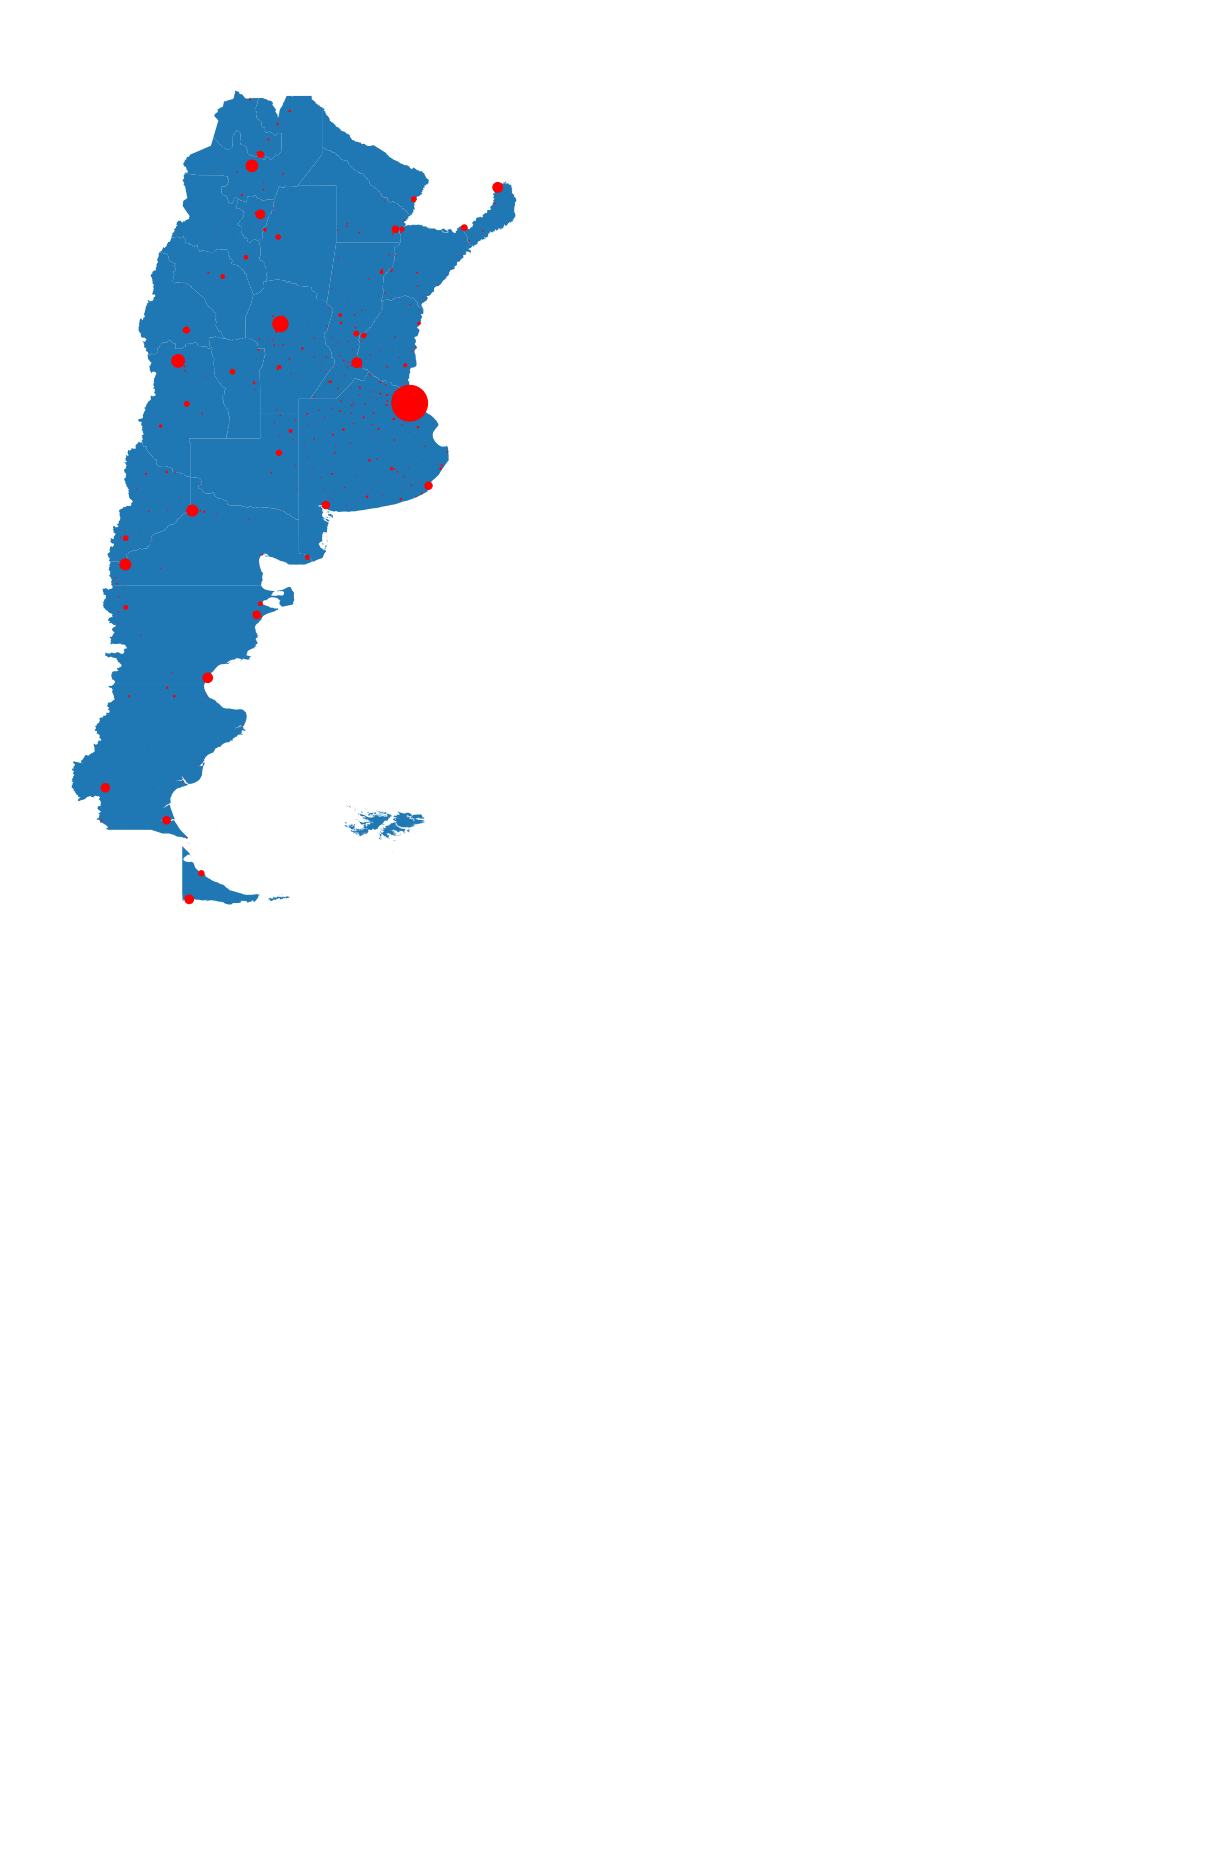

In [15]:
mundo = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
argentina = gpd.read_file('./input/provincia')
fig = plt.figure(figsize=(10,18))
ax_arg = fig.add_subplot(1,1,1)
# mundo[mundo.iso_a3=='ARG'].plot(ax=ax_arg, color='white');
# mundo[mundo.iso_a3=='ARG'].plot(ax=ax_arg);
argentina.plot(ax=ax_arg);


aeropuertos_argentina = airports[pais_es_argentina][['ident','latitude_deg','longitude_deg']]
aeropuertos_argentina = aeropuertos_argentina.merge(actividad_total.to_frame(), left_on='ident', right_index=True)

coordenada_x = aeropuertos_argentina.longitude_deg
coordenada_y = aeropuertos_argentina.latitude_deg
tamanio = aeropuertos_argentina.actividad/650

plt.scatter(coordenada_x, coordenada_y, s=tamanio, c='red');
#
plt.xlim(-75,-50)
plt.ylim(-60,-20)
plt.box('off')
plt.xticks([])
plt.yticks([])
plt.savefig('output/aeropuertos.svg')

# Actividad por mes

Nivel de actividad en cada mes (aterrizajes o despegues de vuelos nacionales o internacionales).

Exluyo el año 2017 por no presentar datos de todos los meses, y promedio los años 2014, 2015 y 2016

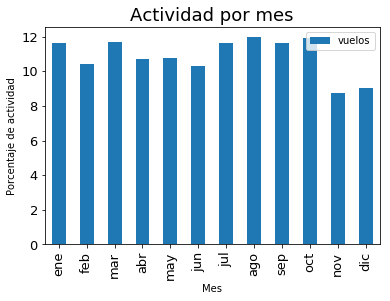

In [16]:
anio_no_es_2017 = eana.fecha_parseada.dt.year != 2017
vuelos_totales = eana[anio_no_es_2017].fecha.value_counts().sum()

#calculo el porcentaje por mes
ranking = (eana.groupby(eana.mes, sort=True,).size()/vuelos_totales*100)#.sort_values(ascending=False)
r_var_coef = ranking.std()/ranking.mean()

#recupero los nombres abreviados de los meses
meses_nombres =  pd.Series(range(1,13),index=range(1,13)).apply(lambda x: calendar.month_abbr[x])

ranking_mes = pd.DataFrame(ranking, columns=['vuelos'])
ranking_mes = ranking_mes.merge(pd.DataFrame(meses_nombres,columns=['mes_nombre']),left_index=True, right_index=True);

ax = ranking_mes.plot(kind='bar', fontsize=13, x='mes_nombre')
ax.set_alpha(0.8)
ax.set_title("Actividad por mes", fontsize=18)
ax.set_ylabel("Porcentaje de actividad")
ax.set_xlabel("Mes");

# Vuelos Cabotaje/Internacional

Exluyo el año 2017 por no presentar datos de todos los meses.

In [17]:
anio_no_es_2017 = eana.fecha_parseada.dt.year != 2017

eana_2014_2016 = eana[anio_no_es_2017]

vuelo_es_despegue = eana_2014_2016.tipo_de_movimiento.str.contains('Despegue')
vuelo_es_internacional = eana_2014_2016.clasificacion_vuelo.str.contains('Internacional')
vuelo_es_cabotaje = eana_2014_2016.clasificacion_vuelo.str.contains('Cabotaje')

vuelo_es_nulo = eana_2014_2016.clasificacion_vuelo.isnull()
vuelo_es_internacional[vuelo_es_nulo] = False
vuelo_es_cabotaje[vuelo_es_nulo] = False

vuelos_internacionales = np.float(len(eana_2014_2016[vuelo_es_internacional & vuelo_es_despegue].index))
vuelos_cabotaje = np.float(len(eana_2014_2016[vuelo_es_cabotaje & vuelo_es_despegue].index))
vuelos_totales = np.int(vuelos_internacionales+vuelos_cabotaje)

ratio_internacionales = round(np.divide(vuelos_internacionales,(vuelos_cabotaje+vuelos_internacionales))*100,2)
ratio_cabotaje = round(np.divide(vuelos_cabotaje,(vuelos_cabotaje+vuelos_internacionales))*100,2)

vuelos_internacionales = np.int(vuelos_internacionales)
vuelos_cabotaje = np.int(vuelos_cabotaje)

- El total de vuelos registrados es de {{vuelos_totales}}.
- El {{ratio_cabotaje}}% ({{vuelos_cabotaje}}) son nacionales.
- El {{ratio_internacionales}}% ({{vuelos_internacionales}}) son internacionales.